In [1]:
import matplotlib.pyplot as plt
import numpy as np

### top view dynamics

In [ ]:
x = np.zeros(6) # x, y, vx, vy, phi, tau


### 6-dof dynamics

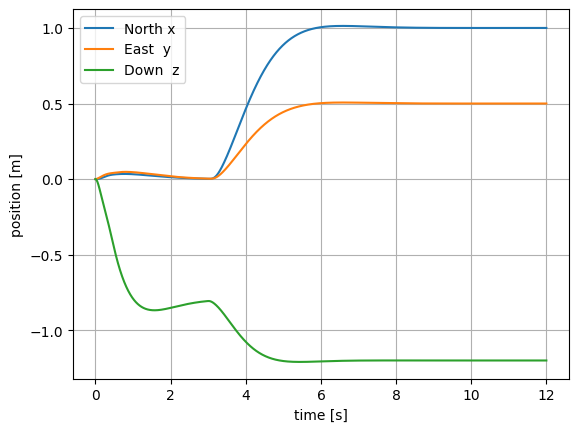

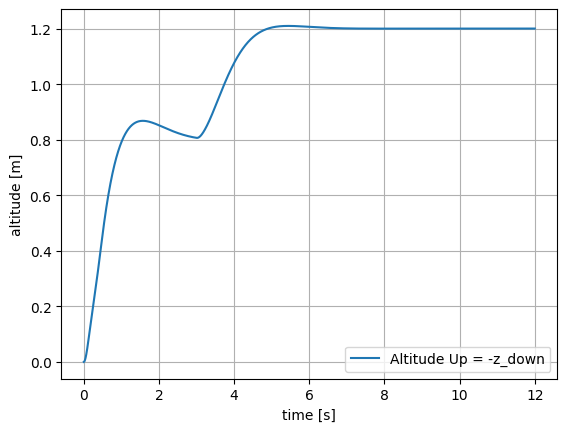

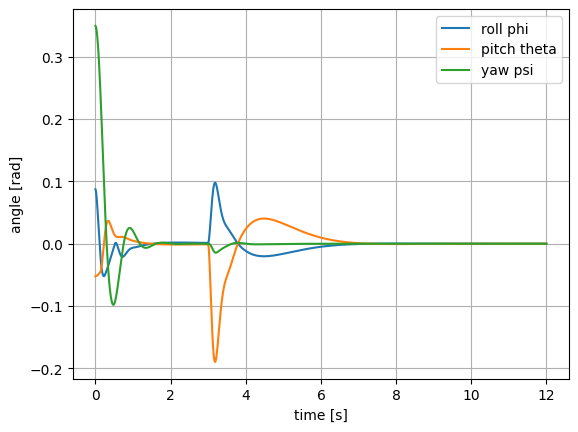

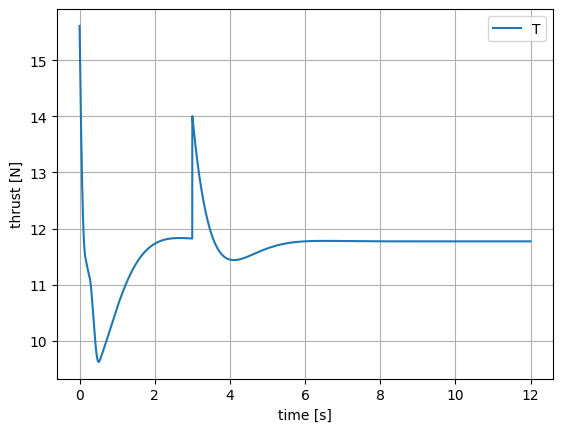

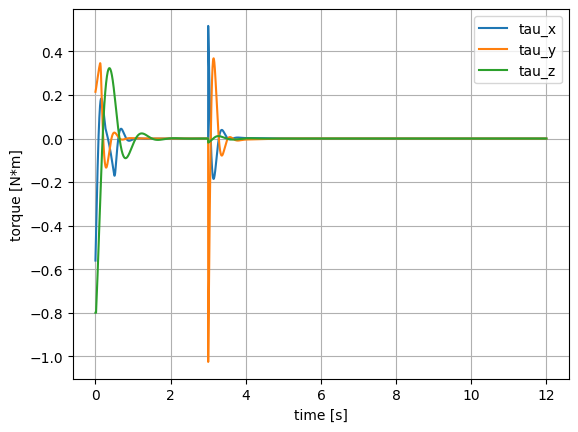

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sat(x, lo, hi):
    return np.minimum(np.maximum(x, lo), hi)

def wrap_pi(a):
    return (a + np.pi) % (2*np.pi) - np.pi

def vee(S):
    # For skew-symmetric S = [[0,-z,y],[z,0,-x],[-y,x,0]] -> [x,y,z]
    return np.array([S[2,1], S[0,2], S[1,0]])

# -----------------------------
# 3D NED quad dynamics (Euler)
# State: p(3), v(3), euler(3), omega(3)  => 12
# Input to dynamics: motor thrusts f(4)
# -----------------------------
class Quad3D_Euler_NED:
    def __init__(self, m=1.2, J=None, arm=0.18, kM=0.02, g=9.81):
        self.m = m
        self.J = np.diag([0.02, 0.02, 0.04]) if J is None else J
        self.Jinv = np.linalg.inv(self.J)
        self.arm = arm
        self.kM = kM
        self.g = g

        # optional simple linear drag in NED velocity
        self.kd_v = 0.05

    # ZYX: R = Rz(psi) Ry(theta) Rx(phi) (body -> NED)
    def R_from_euler(self, phi, theta, psi):
        cφ, sφ = np.cos(phi), np.sin(phi)
        cθ, sθ = np.cos(theta), np.sin(theta)
        cψ, sψ = np.cos(psi), np.sin(psi)
        return np.array([
            [cψ*cθ, cψ*sθ*sφ - sψ*cφ, cψ*sθ*cφ + sψ*sφ],
            [sψ*cθ, sψ*sθ*sφ + cψ*cφ, sψ*sθ*cφ - cψ*sφ],
            [-sθ,   cθ*sφ,            cθ*cφ]
        ], dtype=float)

    # Euler rates: [phi_dot,theta_dot,psi_dot] = E(phi,theta) * [p,q,r]
    def euler_rates(self, phi, theta, omega):
        p, q, r = omega
        cφ, sφ = np.cos(phi), np.sin(phi)
        cθ = np.cos(theta)
        tθ = np.tan(theta)

        eps = 1e-6
        if abs(cθ) < eps:
            cθ = np.sign(cθ)*eps if cθ != 0 else eps

        E = np.array([
            [1.0, sφ*tθ,  cφ*tθ],
            [0.0, cφ,     -sφ   ],
            [0.0, sφ/cθ,  cφ/cθ]
        ], dtype=float)
        return E @ omega

    # Mixer: f1..f4 -> (T, tau)
    def mixer(self, f):
        f1, f2, f3, f4 = f
        T = f1 + f2 + f3 + f4
        tau_x = self.arm * (f2 - f4)
        tau_y = self.arm * (f3 - f1)
        tau_z = self.kM  * (f1 - f2 + f3 - f4)
        return T, np.array([tau_x, tau_y, tau_z], dtype=float)

    # Allocation inverse: (T,tau)->f
    def alloc_inverse(self, T, tau):
        tx, ty, tz = tau
        l = self.arm
        kM = self.kM
        A = np.array([
            [1, 1, 1, 1],
            [0, l, 0,-l],
            [-l,0, l, 0],
            [kM,-kM,kM,-kM]
        ], dtype=float)
        b = np.array([T, tx, ty, tz], dtype=float)
        f = np.linalg.solve(A, b)
        return np.clip(f, 0.0, None)

    def derivatives(self, x, f):
        p = x[0:3]
        v = x[3:6]
        phi, theta, psi = x[6:9]
        omega = x[9:12]

        R = self.R_from_euler(phi, theta, psi)
        T, tau = self.mixer(f)

        # NED translational dynamics:
        # vdot = (1/m) * R*[0,0,-T] + g*e3 - kd*v
        thrust_world = R @ np.array([0.0, 0.0, -T], dtype=float)
        vdot = (1.0/self.m)*thrust_world + np.array([0.0, 0.0, self.g]) - self.kd_v * v

        # rotational dynamics in body frame
        omegadot = self.Jinv @ (tau - np.cross(omega, self.J @ omega))

        eulerdot = self.euler_rates(phi, theta, omega)

        xdot = np.zeros_like(x)
        xdot[0:3] = v
        xdot[3:6] = vdot
        xdot[6:9] = eulerdot
        xdot[9:12] = omegadot
        return xdot

    def step_rk4(self, x, f, dt):
        k1 = self.derivatives(x, f)
        k2 = self.derivatives(x + 0.5*dt*k1, f)
        k3 = self.derivatives(x + 0.5*dt*k2, f)
        k4 = self.derivatives(x + dt*k3, f)
        x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

        # keep angles somewhat bounded (optional)
        x_next[8] = wrap_pi(x_next[8])  # yaw wrap
        return x_next


# -----------------------------
# 3D Cascaded Controller (NED)
# Outer: position -> a_des
# Map: a_des -> (T, R_des) using desired yaw
# Inner: attitude -> tau using SO(3) error (rotation matrix)
# -----------------------------
class CascadedPD3D_NED:
    def __init__(self, quad: Quad3D_Euler_NED):
        self.q = quad

        # Position gains (N,E,D)
        self.Kp_p = np.array([2.0, 2.0, 4.0])
        self.Kd_p = np.array([2.2, 2.2, 3.0])

        # Attitude gains (SO(3) PD)
        self.KR = np.diag([6.0, 6.0, 2.5])
        self.Kw = np.diag([0.35, 0.35, 0.25])

        self.max_T = 3.0 * self.q.m * self.q.g
        self.max_tau = np.array([1.5, 1.5, 0.8])

    def control(self, x, p_des, v_des=np.zeros(3), yaw_des=0.0):
        p = x[0:3]
        v = x[3:6]
        phi, theta, psi = x[6:9]
        w = x[9:12]

        R = self.q.R_from_euler(phi, theta, psi)

        # 1) outer loop: desired accel in NED
        a_des = self.Kp_p*(p_des - p) + self.Kd_p*(v_des - v)

        # 2) map to desired thrust vector in world (NED)
        # from model: vdot = (1/m) * f_world + g*e3 ...
        # want: vdot = a_des  => f_world = m*(a_des - g*e3)
        e3 = np.array([0.0, 0.0, 1.0])
        f_des_world = self.q.m * (a_des - self.q.g * e3)

        # thrust magnitude
        T = np.linalg.norm(f_des_world)
        T = float(sat(T, 0.0, self.max_T))

        # desired body z-axis in world (b3 = R e3_body), and thrust is -T*b3
        # so b3_des = -f_des_world / ||f_des_world||
        eps = 1e-9
        if np.linalg.norm(f_des_world) < eps:
            b3_des = e3.copy()
        else:
            b3_des = -f_des_world / (np.linalg.norm(f_des_world) + eps)

        # desired yaw defines a reference b1 direction in the horizontal plane
        b1c = np.array([np.cos(yaw_des), np.sin(yaw_des), 0.0])

        # construct full R_des from b3_des and yaw reference
        b2_des = np.cross(b3_des, b1c)
        if np.linalg.norm(b2_des) < eps:
            b2_des = np.array([0.0, 1.0, 0.0])  # fallback
        else:
            b2_des /= np.linalg.norm(b2_des)

        b1_des = np.cross(b2_des, b3_des)

        R_des = np.column_stack([b1_des, b2_des, b3_des])

        # 3) attitude error on SO(3)
        # e_R = 0.5 * vee(R_des^T R - R^T R_des)
        e_R = 0.5 * vee(R_des.T @ R - R.T @ R_des)
        e_w = w  # desired body rates ~ 0 for now (simple)

        # PD torque (optionally add gyro compensation)
        tau = -(self.KR @ e_R) - (self.Kw @ e_w) + np.cross(w, self.q.J @ w)
        tau = sat(tau, -self.max_tau, self.max_tau)

        return T, tau, a_des, R_des


# -----------------------------
# Demo simulation
# -----------------------------
if __name__ == "__main__":
    quad = Quad3D_Euler_NED(m=1.2, arm=0.18, kM=0.02)
    ctrl = CascadedPD3D_NED(quad)

    dt = 0.002
    T_total = 12.0
    N = int(T_total / dt)

    # state: [p(3), v(3), euler(3), w(3)]
    x = np.zeros(12)
    x[6:9] = np.deg2rad([5.0, -3.0, 20.0])  # initial attitude disturbance

    hist = np.zeros((N, 12))
    T_hist = np.zeros(N)
    tau_hist = np.zeros((N, 3))

    for i in range(N):
        t = i * dt

        # NED: z is Down(+). "1m 위로 떠라" => z_des = -1
        if t < 3.0:
            p_des = np.array([0.0, 0.0, -0.8])
        else:
            p_des = np.array([1.0, 0.5, -1.2])  # move North/East while keeping higher altitude

        yaw_des = 0.0

        T, tau, a_des, R_des = ctrl.control(x, p_des, yaw_des=yaw_des)

        # allocate to motors
        f = quad.alloc_inverse(T, tau)

        # integrate
        x = quad.step_rk4(x, f, dt)

        hist[i] = x
        T_hist[i] = T
        tau_hist[i] = tau

    t = np.arange(N) * dt

    # Position (NED)
    plt.figure()
    plt.plot(t, hist[:,0], label="North x")
    plt.plot(t, hist[:,1], label="East  y")
    plt.plot(t, hist[:,2], label="Down  z")
    plt.grid(True); plt.legend()
    plt.xlabel("time [s]"); plt.ylabel("position [m]")
    plt.show()

    # Altitude (Up = -Down)
    plt.figure()
    plt.plot(t, -hist[:,2], label="Altitude Up = -z_down")
    plt.grid(True); plt.legend()
    plt.xlabel("time [s]"); plt.ylabel("altitude [m]")
    plt.show()

    # Euler angles
    plt.figure()
    plt.plot(t, hist[:,6], label="roll phi")
    plt.plot(t, hist[:,7], label="pitch theta")
    plt.plot(t, hist[:,8], label="yaw psi")
    plt.grid(True); plt.legend()
    plt.xlabel("time [s]"); plt.ylabel("angle [rad]")
    plt.show()

    # Inputs
    plt.figure()
    plt.plot(t, T_hist, label="T")
    plt.grid(True); plt.legend()
    plt.xlabel("time [s]"); plt.ylabel("thrust [N]")
    plt.show()

    plt.figure()
    plt.plot(t, tau_hist[:,0], label="tau_x")
    plt.plot(t, tau_hist[:,1], label="tau_y")
    plt.plot(t, tau_hist[:,2], label="tau_z")
    plt.grid(True); plt.legend()
    plt.xlabel("time [s]"); plt.ylabel("torque [N*m]")
    plt.show()


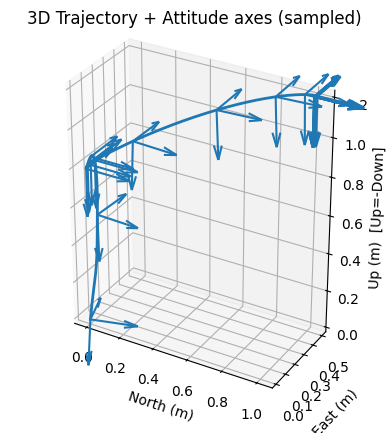

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# hist shape: (N, 12) with state [p(3), v(3), euler(3), w(3)]
# quad must have method R_from_euler(phi, theta, psi)

def plot_3d_traj_with_attitude(hist, quad, stride=200, axis_len=0.2):
    """
    stride: 자세축을 몇 스텝마다 한 번씩 그릴지 (너무 촘촘하면 지저분함)
    axis_len: 바디축 화살표 길이
    """
    p_ned = hist[:, 0:3]
    phi = hist[:, 6]
    theta = hist[:, 7]
    psi = hist[:, 8]

    # 보기 좋게 Up으로 변환: (N, E, U)
    xN = p_ned[:, 0]
    yE = p_ned[:, 1]
    zU = -p_ned[:, 2]   # Up = -Down

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    # Trajectory
    ax.plot(xN, yE, zU, linewidth=2)

    # Attitude frames (body axes in world)
    for i in range(0, len(hist), stride):
        R = quad.R_from_euler(phi[i], theta[i], psi[i])  # body -> NED
        # Convert NED to NEU (flip z) for display
        # NED vector [x,y,z] -> Display [x, y, -z]
        # So rotation for display is: S * R, where S=diag(1,1,-1) applied to world vectors
        S = np.diag([1.0, 1.0, -1.0])
        R_disp = S @ R

        # Body axes in display/world (columns are b1, b2, b3)
        b1 = R_disp[:, 0]  # body x axis
        b2 = R_disp[:, 1]  # body y axis
        b3 = R_disp[:, 2]  # body z axis (down in body, but displayed with z flipped)

        px, py, pz = xN[i], yE[i], zU[i]

        ax.quiver(px, py, pz, b1[0], b1[1], b1[2], length=axis_len, normalize=True)
        ax.quiver(px, py, pz, b2[0], b2[1], b2[2], length=axis_len, normalize=True)
        ax.quiver(px, py, pz, b3[0], b3[1], b3[2], length=axis_len, normalize=True)

    ax.set_xlabel("North (m)")
    ax.set_ylabel("East (m)")
    ax.set_zlabel("Up (m)  [Up=-Down]")
    ax.set_title("3D Trajectory + Attitude axes (sampled)")

    # equal-ish aspect
    ax.set_box_aspect([np.ptp(xN)+1e-6, np.ptp(yE)+1e-6, np.ptp(zU)+1e-6])

    plt.show()

# 사용 예:
plot_3d_traj_with_attitude(hist, quad, stride=300, axis_len=0.25)
